Primero es necesario filtrar las variables de interés *disburments* a solo las instituciones: 'public', 'private' y 'proprietary'

In [149]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import skew, kurtosis
import warnings
import matplotlib.pyplot as plt


df = pd.read_csv("../data/clean/dashboard_2010_clean.csv")

tipos = ['public', 'private', 'proprietary']

df_filtrado = df[df['School Type'].str.lower().isin(tipos)]

df_filtrado

,OPE ID,School,State,Zip Code,School Type,FFEL SUBSIDIZED Recipients,FFEL SUBSIDIZED # of Loans Originated,FFEL SUBSIDIZED $ of Loans Originated,FFEL SUBSIDIZED # of Disbursements,FFEL SUBSIDIZED $ of Disbursements,...,FFEL PARENT PLUS Recipients,FFEL PARENT PLUS # of Loans Originated,FFEL PARENT PLUS $ of Loans Originated,FFEL PARENT PLUS # of Disbursements,FFEL PARENT PLUS $ of Disbursements,FFEL GRAD PLUS Recipients,FFEL GRAD PLUS # of Loans Originated,FFEL GRAD PLUS $ of Loans Originated,FFEL GRAD PLUS # of Disbursements,FFEL GRAD PLUS $ of Disbursements
0,106100,ALASKA PACIFIC UNIVERSITY,AK,995084672,PRIVATE,5,5,16999,6,21249,...,0,0,0,1,93,0,0,0,0,0
1,106300,UNIVERSITY OF ALASKA FAIRBANKS,AK,997757500,PUBLIC,99,104,320529,110,316818,...,2,2,8157,2,8157,0,0,0,0,0
2,106500,UNIVERSITY OF ALASKA SOUTHEAST,AK,998018680,PUBLIC,38,40,78165,57,121239,...,0,0,0,0,0,1,1,3233,1,3233
3,1146200,UNIVERSITY OF ALASKA ANCHORAGE,AK,995088050,PUBLIC,10,10,15851,46,80427,...,1,1,5000,2,8333,1,1,8500,1,8500
4,2541000,ALASKA CAREER COLLEGE,AK,995071033,PROPRIETARY,117,118,372926,274,434764,...,5,5,37500,8,23616,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788,393200,UNIVERSITY OF WYOMING,WY,820713663,PUBLIC,31,31,104491,39,107241,...,9,9,28150,9,28150,6,6,30446,6,30446
3789,393300,WESTERN WYOMING COMMUNITY COLLEGE,WY,829010428,PUBLIC,4,4,11521,6,12820,...,0,0,0,0,0,0,0,0,0,0
3790,728900,CENTRAL WYOMING COLLEGE,WY,825012215,PUBLIC,52,54,82101,54,81908,...,0,0,0,0,0,0,0,0,0,0
3791,915700,WYOTECH,WY,820729519,PROPRIETARY,1805,1933,3101590,3228,4599611,...,559,627,3895466,949,6113387,0,0,0,0,0


Se debe mencionar la asimetría y la curtosis para la elección de escala log

 señala que la curtosis describe la forma de una distribución en términos de su “apuntamiento” y el peso de sus colas, mientras que la asimetría (skewness) refleja la falta de simetría respecto a la media. En conjunto, ambos momentos estandarizados complementan la media y la varianza al caracterizar la forma total de una distribución.

De manera que hacer una transformación logarítmica es ideal cuando los datos presentan alta asimetría o curtosis, esto debido a que ayuda a corregir la falta de normalidad y a estabilizar la varianza, lo que mejora la validez de los análisis posteriores.

In [150]:
def resumen_disbursements(df_filtrado, tipo_col = 'School Type'):
    """
    Calcula asimetría, curtosis y recomendación de transformación logarítmica
    para todas las variables que contengan 'Disbursements', separadas por tipo de universidad.
    Devuelve un DataFrame resumen.
    """
    cols_disb = [c for c in df_filtrado.columns if 'Disbursements' in c]
    tipos = df_filtrado[tipo_col].dropna().unique()

    registros = []

    for col in cols_disb:
        for tipo in tipos:
            data = df_filtrado[df_filtrado[tipo_col] == tipo][col].dropna()

            # Cálculo en escala original
            s_orig = skew(data)
            k_orig = kurtosis(data)

            # Escala log(1+x)
            data_log = np.log1p(data)
            s_log = skew(data_log)
            k_log = kurtosis(data_log)

            # Regla de decisión: preferir log si reduce skew y kurtosis
            mejor_log = (abs(s_log) < abs(s_orig)) and (abs(k_log - 3) < abs(k_orig - 3))
            recomendacion = "usar log" if mejor_log else "mantener original"

            registros.append({
                "variable": col,
                "tipo_universidad": tipo,
                "skew_original": round(s_orig, 3),
                "kurt_original": round(k_orig, 3),
                "skew_log": round(s_log, 3),
                "kurt_log": round(k_log, 3),
                "recomendacion": recomendacion
            })

    resumen = pd.DataFrame(registros)
    return resumen.sort_values(["variable", "tipo_universidad"]).reset_index(drop=True)

In [151]:
resumen_disbursements(df_filtrado)

,variable,tipo_universidad,skew_original,kurt_original,skew_log,kurt_log,recomendacion
0,FFEL GRAD PLUS # of Disbursements,PRIVATE,7.702,77.896,1.436,0.920,usar log
1,FFEL GRAD PLUS # of Disbursements,PROPRIETARY,13.205,198.856,5.492,31.234,usar log
2,FFEL GRAD PLUS # of Disbursements,PUBLIC,10.925,151.004,3.017,8.619,usar log
3,FFEL GRAD PLUS $ of Disbursements,PRIVATE,7.861,77.325,0.608,-1.414,usar log
4,FFEL GRAD PLUS $ of Disbursements,PROPRIETARY,19.409,460.677,4.272,16.882,usar log
5,FFEL GRAD PLUS $ of Disbursements,PUBLIC,12.951,237.620,2.017,2.326,usar log
6,FFEL PARENT PLUS # of Disbursements,PRIVATE,12.549,182.789,0.871,0.582,usar log
7,FFEL PARENT PLUS # of Disbursements,PROPRIETARY,8.635,101.739,0.572,-0.640,usar log
8,FFEL PARENT PLUS # of Disbursements,PUBLIC,6.296,52.593,1.156,0.524,usar log
9,FFEL PARENT PLUS $ of Disbursements,PRIVATE,12.435,193.841,-0.425,-1.601,usar log


Por lo que se prosigue aplicando escala logaritmica a todas las variables que contengan *Disbursements* en la data

In [152]:
cols_disb = [c for c in df_filtrado.columns if "Disbursements" in c]
df_log = df_filtrado.copy()
df_log[cols_disb] = np.log1p(df_filtrado[cols_disb])

df_log

,OPE ID,School,State,Zip Code,School Type,FFEL SUBSIDIZED Recipients,FFEL SUBSIDIZED # of Loans Originated,FFEL SUBSIDIZED $ of Loans Originated,FFEL SUBSIDIZED # of Disbursements,FFEL SUBSIDIZED $ of Disbursements,...,FFEL PARENT PLUS Recipients,FFEL PARENT PLUS # of Loans Originated,FFEL PARENT PLUS $ of Loans Originated,FFEL PARENT PLUS # of Disbursements,FFEL PARENT PLUS $ of Disbursements,FFEL GRAD PLUS Recipients,FFEL GRAD PLUS # of Loans Originated,FFEL GRAD PLUS $ of Loans Originated,FFEL GRAD PLUS # of Disbursements,FFEL GRAD PLUS $ of Disbursements
0,106100,ALASKA PACIFIC UNIVERSITY,AK,995084672,PRIVATE,5,5,16999,1.945910,9.964112,...,0,0,0,0.693147,4.543295,0,0,0,0.000000,0.000000
1,106300,UNIVERSITY OF ALASKA FAIRBANKS,AK,997757500,PUBLIC,99,104,320529,4.709530,12.666086,...,2,2,8157,1.098612,9.006754,0,0,0,0.000000,0.000000
2,106500,UNIVERSITY OF ALASKA SOUTHEAST,AK,998018680,PUBLIC,38,40,78165,4.060443,11.705527,...,0,0,0,0.000000,0.000000,1,1,3233,0.693147,8.081475
3,1146200,UNIVERSITY OF ALASKA ANCHORAGE,AK,995088050,PUBLIC,10,10,15851,3.850148,11.295118,...,1,1,5000,1.098612,9.028099,1,1,8500,0.693147,9.047939
4,2541000,ALASKA CAREER COLLEGE,AK,995071033,PROPRIETARY,117,118,372926,5.616771,12.982561,...,5,5,37500,2.197225,10.069722,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788,393200,UNIVERSITY OF WYOMING,WY,820713663,PUBLIC,31,31,104491,3.688879,11.582843,...,9,9,28150,2.302585,10.245338,6,6,30446,1.945910,10.323743
3789,393300,WESTERN WYOMING COMMUNITY COLLEGE,WY,829010428,PUBLIC,4,4,11521,1.945910,9.458840,...,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000
3790,728900,CENTRAL WYOMING COLLEGE,WY,825012215,PUBLIC,52,54,82101,4.007333,11.313364,...,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000
3791,915700,WYOTECH,WY,820729519,PROPRIETARY,1805,1933,3101590,8.079928,15.341483,...,559,627,3895466,6.856462,15.625992,0,0,0,0.000000,0.000000


## Comprensión de los criterios AIC, BIC, KS stat y KS p

Antes de proceder al ajuste de las distribuciones marginales, es fundamental comprender los indicadores estadísticos que permiten evaluar la bondad de ajuste y la parsimonia del modelo. Entre ellos destacan el *Akaike Information Criterion (AIC)*, el *Bayesian Information Criterion (BIC)* y las pruebas de bondad de ajuste de Kolmogorov–Smirnov (KS stat y KS p).

### Akaike Information Criterion (AIC)

El **AIC**, propuesto por Akaike, se utiliza para comparar modelos en términos de la calidad del ajuste penalizando la complejidad. Se define como:

$$
AIC = 2k - 2\ln(\hat{L})
$$

donde \(k\) es el número de parámetros estimados y \(\hat{L}\) la máxima verosimilitud.  
Un valor menor de AIC indica un modelo más eficiente, es decir, con mejor equilibrio entre ajuste y simplicidad.

### Bayesian Information Criterion (BIC)

El **BIC** [@Schwarz1978] también penaliza la complejidad, pero de manera más estricta, especialmente cuando el tamaño muestral es grande:

$$
BIC = k\ln(n) - 2\ln(\hat{L})
$$

donde \(n\) es el número de observaciones.  
Este criterio tiende a favorecer modelos más simples que el AIC, y es particularmente útil cuando se busca identificar la distribución con mayor evidencia bayesiana.

Ambos criterios permiten seleccionar entre diferentes familias de distribuciones (por ejemplo, normal, lognormal, gamma o Weibull) en función de su verosimilitud ajustada.  
No obstante, estos criterios no prueban la adecuación del modelo de manera absoluta, sino que comparan entre modelos candidatos.

### Prueba de Kolmogorov–Smirnov (KS)

Para evaluar si una distribución ajustada representa correctamente los datos, se utiliza la **prueba de Kolmogorov–Smirnov (KS)**, que contrasta la función de distribución empírica \(F_n(x)\) con la función teórica \(F(x)\).  
El estadístico KS se define como:

$$
D = \sup_x |F_n(x) - F(x)|
$$

Un valor bajo de \(D\) (KS stat) y un valor alto del p-valor (KS p) indican que no hay evidencia significativa para rechazar la hipótesis nula de que los datos provienen de la distribución teórica ajustada.  
Por tanto, la prueba KS proporciona una validación empírica del ajuste marginal, complementando los criterios AIC y BIC.



Por lo tanto, la comprensión de estos indicadores permite seleccionar las distribuciones marginales más adecuadas antes de construir cópulas o modelos multivariados, garantizando que la dependencia se estudie sobre variables correctamente modeladas y normalizadas [@decarlo1997]

In [ ]:
def fit_distributions(series, distribs = None):
    """
    Ajusta varias distribuciones a una variable y devuelve métricas de bondad de ajuste.
    """
    if distribs is None:
        distribs = ["lognorm", "gamma", "expon", "norm", "t", "weibull_min", "skewnorm", "johnsonsu", "laplace"]

    data = series.dropna().values
    results = []

    for name in distribs:
        dist = getattr(st, name)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            params = dist.fit(data)
        loglik = np.sum(dist.logpdf(data, *params))
        k = len(params)
        n = len(data)
        aic = 2*k - 2*loglik
        bic = k*np.log(n) - 2*loglik
        ks_stat, ks_p = st.kstest(data, name, args=params)
        results.append({
            'distribution': name,
            'params': params,
            'AIC': aic,
            'BIC': bic,
            'KS_stat': ks_stat,
            'KS_p': ks_p
        })
    df_results = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
    return df_results

def resumen_fit_distributions(df_log, col_name):
    """
    Devuelve un DataFrame con las mejores distribuciones (por AIC) para una variable.
    """
    serie = df_log[col_name].dropna()
    ajuste = fit_distributions(serie)

    filas = []
    
    for i in range(7):
        fila = ajuste.iloc[i]
        filas.append({
            'variable': col_name,
            'distribution': fila['distribution'],
            'params': fila['params'],
            'AIC': fila['AIC'],
            'BIC': fila['BIC'],
            'KS_stat': fila['KS_stat'],
            'KS_p': fila['KS_p']
        })

    resumen = pd.DataFrame(filas)
    return resumen

In [ ]:
def plot_best_fit_distribution(df_log, col_name):
    """
    Grafica los datos junto con la mejor distribución ajustada según AIC.
    """
    serie = df_log[col_name].dropna().values
    ajuste = fit_distributions(pd.Series(serie))
    mejor = ajuste.iloc[0]

    dist_name = mejor['distribution']
    params = mejor['params']
    dist = getattr(st, dist_name)

    x = np.linspace(min(serie), max(serie), 300)
    pdf_teo = dist.pdf(x, *params)

    plt.figure(figsize=(8,5))
    plt.hist(serie, bins='auto', density=True, alpha=0.6, color='lightsteelblue', label='Datos')
    plt.plot(x, pdf_teo, 'r-', lw=2, label=f'{dist_name} fit')

    plt.title(
        f"{col_name}\nMejor ajuste: {dist_name} | AIC={mejor['AIC']:.2f} | KS={mejor['KS_stat']:.3f}",
        fontsize=12, fontweight='bold'
    )
    plt.xlabel("Valores (log1p)")
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mejor

# Aparta de PIT

In [153]:
def apply_pit(series, dist_name, params):
    """
    Aplica el Probability Integral Transform (PIT) a una serie de datos
    usando la CDF de la distribución ajustada.
    """
    series = series.dropna()
    dist = getattr(st, dist_name)

    u = dist.cdf(series, *params)
    u = np.clip(u, 1e-12, 1 - 1e-12)
    
    return pd.Series(u, index=series.index, name=f"{series.name}__PIT")

Ahora es necesario generar columnas con PIT en el df

In [154]:
for col in cols_disb:
    dist = resumen_fit_distributions(df_log, col)
    dist_name = dist["distribution"][0]
    params = dist["params"][0]

    df_log[f"{col}_PIT"] = apply_pit(df_log[col], dist_name, params)

In [155]:
df_log

,OPE ID,School,State,Zip Code,School Type,FFEL SUBSIDIZED Recipients,FFEL SUBSIDIZED # of Loans Originated,FFEL SUBSIDIZED $ of Loans Originated,FFEL SUBSIDIZED # of Disbursements,FFEL SUBSIDIZED $ of Disbursements,...,FFEL GRAD PLUS # of Disbursements,FFEL GRAD PLUS $ of Disbursements,FFEL SUBSIDIZED # of Disbursements_PIT,FFEL SUBSIDIZED $ of Disbursements_PIT,FFEL UNSUBSIDIZED # of Disbursements_PIT,FFEL UNSUBSIDIZED $ of Disbursements_PIT,FFEL PARENT PLUS # of Disbursements_PIT,FFEL PARENT PLUS $ of Disbursements_PIT,FFEL GRAD PLUS # of Disbursements_PIT,FFEL GRAD PLUS $ of Disbursements_PIT
0,106100,ALASKA PACIFIC UNIVERSITY,AK,995084672,PRIVATE,5,5,16999,1.945910,9.964112,...,0.000000,0.000000,0.141492,0.227336,0.194372,0.245006,6.596125e-01,0.540988,2.611125e-07,0.000006
1,106300,UNIVERSITY OF ALASKA FAIRBANKS,AK,997757500,PUBLIC,99,104,320529,4.709530,12.666086,...,0.000000,0.000000,0.596735,0.661274,0.653522,0.672016,6.980002e-01,0.555096,2.611125e-07,0.000006
2,106500,UNIVERSITY OF ALASKA SOUTHEAST,AK,998018680,PUBLIC,38,40,78165,4.060443,11.705527,...,0.693147,8.081475,0.474302,0.470600,0.526183,0.550696,5.958858e-07,0.003287,5.808472e-01,0.660326
3,1146200,UNIVERSITY OF ALASKA ANCHORAGE,AK,995088050,PUBLIC,10,10,15851,3.850148,11.295118,...,0.693147,9.047939,0.434813,0.399065,0.469487,0.474210,6.980002e-01,0.555144,5.808472e-01,0.667481
4,2541000,ALASKA CAREER COLLEGE,AK,995071033,PROPRIETARY,117,118,372926,5.616771,12.982561,...,0.000000,0.000000,0.753166,0.724073,0.745528,0.743458,7.541226e-01,0.557389,2.611125e-07,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788,393200,UNIVERSITY OF WYOMING,WY,820713663,PUBLIC,31,31,104491,3.688879,11.582843,...,1.945910,10.323743,0.404982,0.448341,0.569481,0.595660,7.578081e-01,0.557744,6.670550e-01,0.675818
3789,393300,WESTERN WYOMING COMMUNITY COLLEGE,WY,829010428,PUBLIC,4,4,11521,1.945910,9.458840,...,0.000000,0.000000,0.141492,0.183430,0.217512,0.183703,5.958858e-07,0.003287,2.611125e-07,0.000006
3790,728900,CENTRAL WYOMING COLLEGE,WY,825012215,PUBLIC,52,54,82101,4.007333,11.313364,...,0.000000,0.000000,0.464283,0.402062,0.479141,0.441811,5.958858e-07,0.003287,2.611125e-07,0.000006
3791,915700,WYOTECH,WY,820729519,PROPRIETARY,1805,1933,3101590,8.079928,15.341483,...,0.000000,0.000000,0.974179,0.972049,0.971550,0.968942,8.379402e-01,0.566404,2.611125e-07,0.000006


In [157]:
def diagnosticar_pit(df, col_name):
    """
    Genera diagnóstico visual del PIT:
    - Histograma del PIT
    - CDF empírica vs teórica (U(0,1))
    - QQ-plot del PIT vs uniforme
    """
    u = df[col_name].dropna().values

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].hist(u, bins='auto', density=True, color='lightsteelblue', edgecolor='gray', alpha=0.7)
    axes[0].axhline(1, color='red', linestyle='--', label='Uniforme ideal')
    axes[0].set_title("Histograma del PIT", fontsize=11, fontweight='bold')
    axes[0].set_xlabel("u_i")
    axes[0].set_ylabel("Densidad")
    axes[0].legend()
    
    u_sorted = np.sort(u)
    cdf_emp = np.arange(1, len(u_sorted)+1) / len(u_sorted)
    cdf_teo = u_sorted  # CDF teórica de una uniforme(0,1)
    axes[1].plot(u_sorted, cdf_emp, label="CDF empírica", color="steelblue")
    axes[1].plot(u_sorted, cdf_teo, label="CDF teórica U(0,1)", color="red", linestyle="--")
    axes[1].fill_between(u_sorted, cdf_emp, cdf_teo, color="gray", alpha=0.2)
    axes[1].set_title("CDF empírica vs teórica", fontsize=11, fontweight='bold')
    axes[1].set_xlabel("u_i")
    axes[1].set_ylabel("Probabilidad acumulada")
    axes[1].legend()

    st.probplot(u, dist="uniform", plot=axes[2])
    axes[2].get_lines()[1].set_color('red') 
    axes[2].set_title("QQ-plot vs Uniforme(0,1)", fontsize=11, fontweight='bold')

    fig.suptitle(f"Diagnóstico del PIT — {col_name}", fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

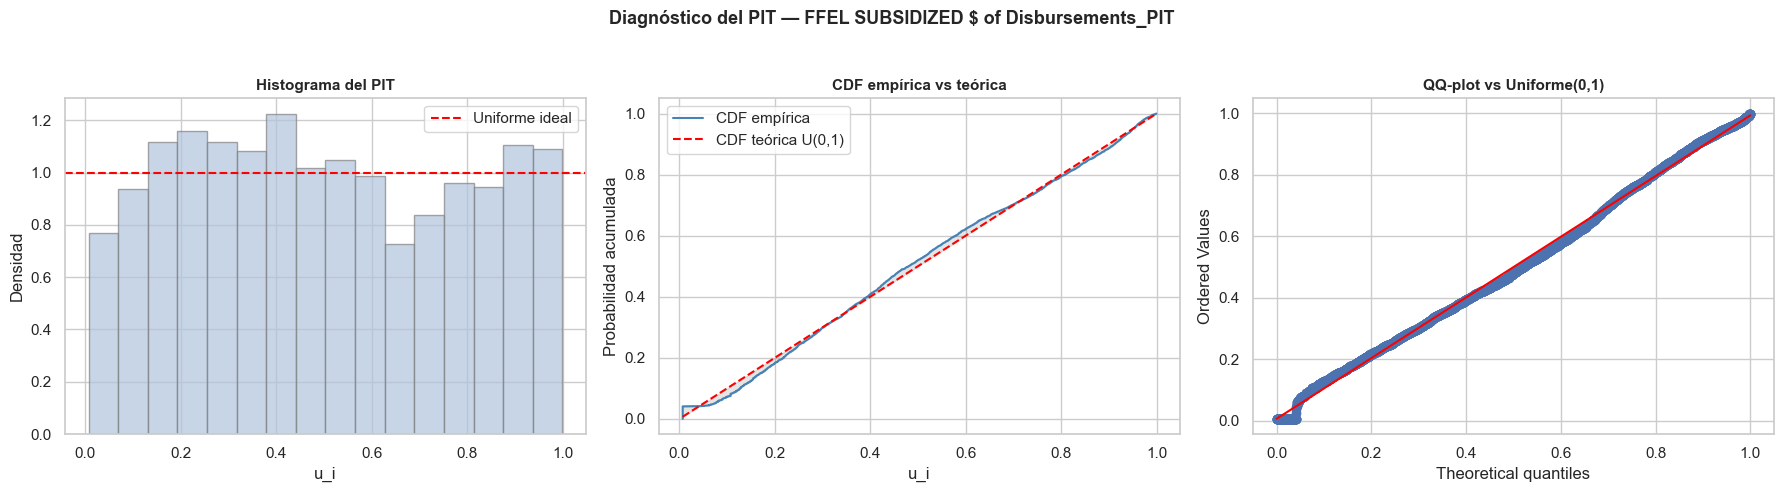

In [159]:
diagnosticar_pit(df_log, "FFEL SUBSIDIZED $ of Disbursements_PIT")